# Unravelling the interplay between flood model selection, simulations outcomes, and resulting flood risk – a case study in the Ganges-Brahmaputra delta

## Introduction

There are various (hydrological and hydrodynamic) models out there that are able to produce flood maps, either for given return perios or for a given date. Due to the different model development approaches used and the way modelling decisions are made <cite data-cite="6222060/HXDBCXUI"></cite>, there is an inherent disagreement between simulated flood extent. A comparison study showed that a set of flood models only agrees for around a third of simulated flood extent <cite data-cite="6222060/BBVBBSUF"></cite>.

It is clear that, from a flood risk management perspective, there must a thorough understanding of the accuracy and uncertainties of inundation maps produced by models.

In this work, we aim at disentangling this complexity (a bit at least) and to show how the choice of a model will have direct influence on

* accuracy of the simulated flood extent;
* the resulting number of people exposed due to this event.

Contact details: j.m.hoch@uu.nl

Get started with importing all required packages.

In [1]:
import numpy as np
from floodimpact.contingency import contingency
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams, colors
import rasterio as rio
from rasterio.plot import show
import earthpy.plot as ep
import os, sys
import pandas as pd
import seaborn as sns
from IPython.display import Image

## Approach

To test how model choice influences outcomes, we used flood maps simulated by three models:

* the global hydrological model PCR-GLOBWB <cite data-cite="6222060/3XYPXIHB"></cite>;
* the global routing model CaMa-Flood <cite data-cite="6222060/BT23YQZR"></cite>;
* and the hydrodynamic model Lisflood-FP <cite data-cite="6222060/N456NDVK"></cite>.

By means of the [GLOFRIM](https://glofrim.readthedocs.io/en/latest/) framework, it was possible to establish a cascade of coupled models. 

This means, that PCR-GLOBWB output directly forces CaMa-Flood, which in turn forces a (nested) Lisflood-FP models (see picture below). This corresponds with cascade 3 in the above-shown picture. The chosen approach has the benefitial consequence that all boundary condtions can be considered to be aligned. One source of model difference down!

The original spatial resolution of the models differs, with Lisflood-FP having the finest spatial resolution (500 m spatial resolution). It was thus necessary to first downscale the output from PCR-GLOBWB and CaMa-Flood. Both models have built-in tools for that and yes, these tools differ as well! 

In a first check, we determine the accuracy of the simulated flood extent (note, this was already down in the above-mentioned NHESS publication). 

Once we have an estimate how good the models match observations, we continue with overlying the simulated flood extents with population data from the [WorldPOP](https://www.worldpop.org/) project. As a result, we obtain the number of people affected for this flood extent and a first-order idea how model selection influences this estimate.

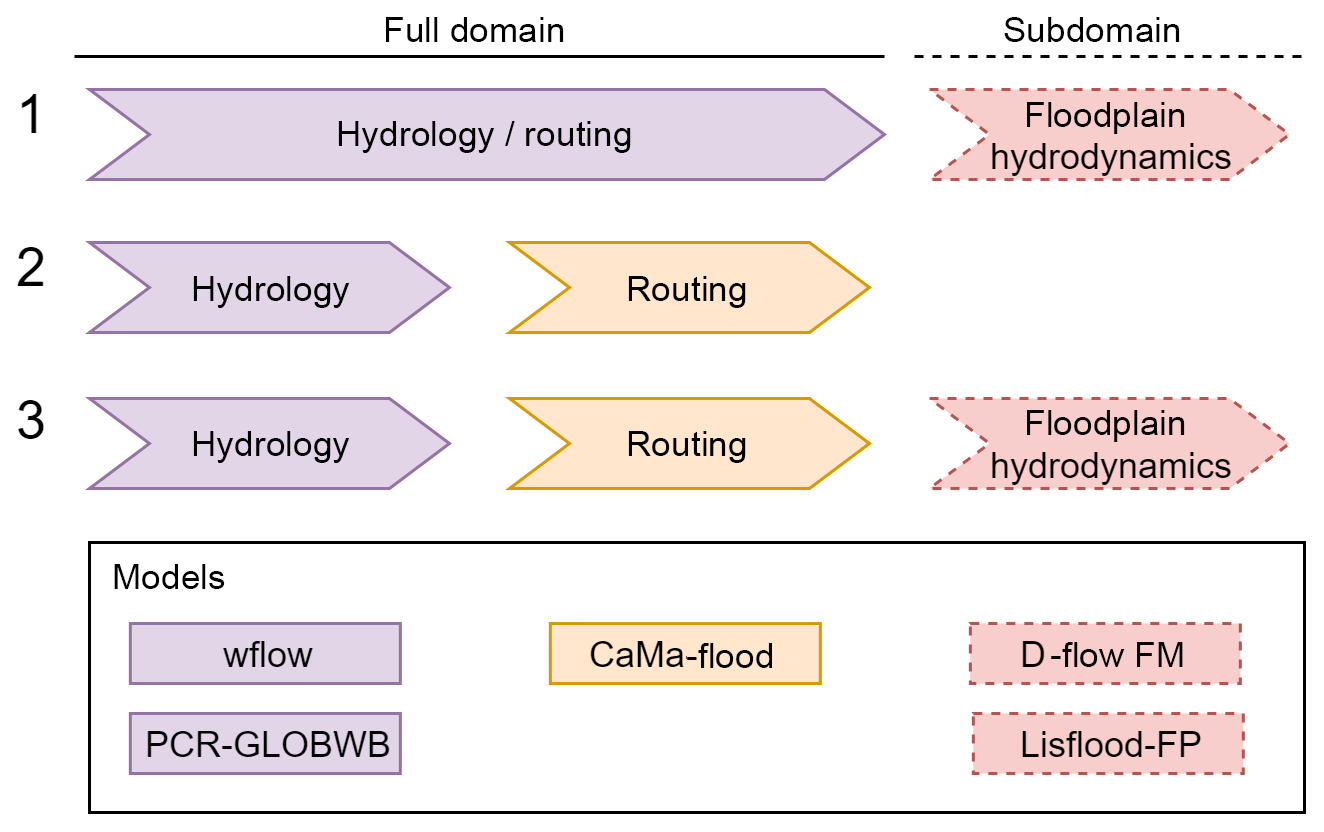

In [113]:
Image(filename='pics/coupling.png', width = 600, height = 300)

### Case study

As case study, we chose the Ganges-Brahmaputra basin. We performed coupled calculations for all three models for the period 2004 - 2009. Simulated flood extent was compared for the date 18 August 2007.

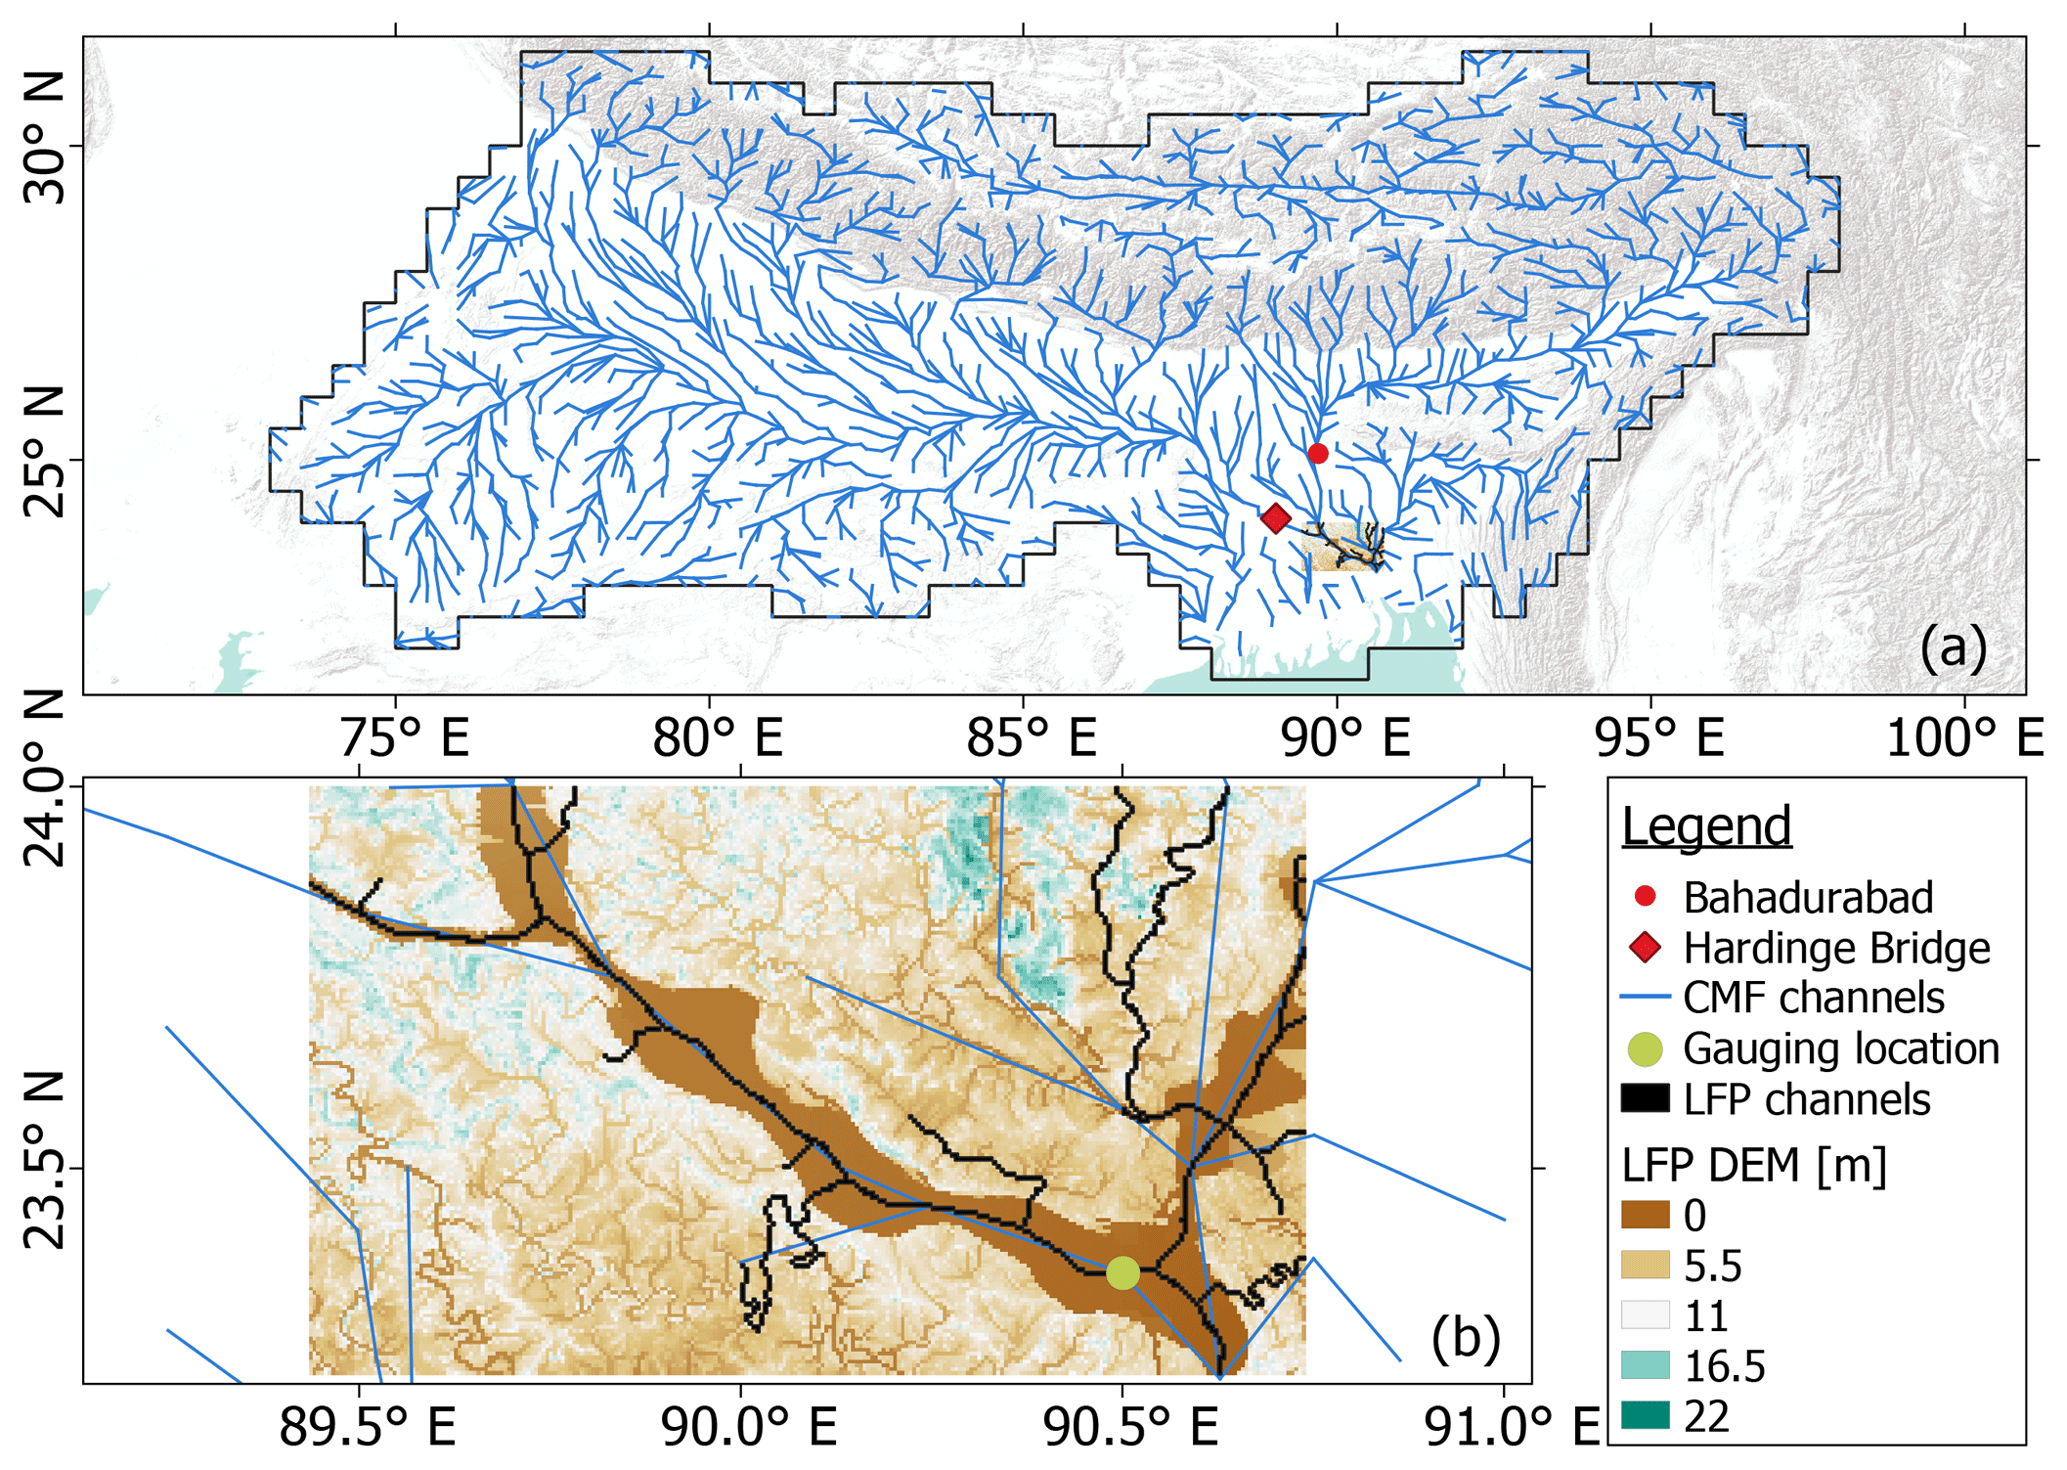

In [114]:
Image(filename='pics/study_area.png', width = 600, height = 300)

## Settings

In [115]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

rcParams['font.sans-serif'] = ['Arial']

matplotlib.rc('font', **font)

In [116]:
if not os.path.exists('out'):
    os.mkdir('out')

## Data

### Simulated extent

Now get the files with boolean maps of simulated flood extent, i.e. 1 is flooded and 0 is not flooded, and open them with rasterio.

In [117]:
PCR_d = rio.open('data/PCR_clipped_reprojected_boolean.tiff')

In [118]:
LFP_d = rio.open('data/LFP_reprojected_boolean.tiff')

In [119]:
CMF_d = rio.open('data/CMF_clipped_reprojected_boolean.tiff')

Store them in a dictionary for easier accessibility.

In [120]:
flood_maps = {'PCR-GLOBWB':PCR_d, 
              'CaMa-Flood':CMF_d,
              'Lisflood-FP':LFP_d, 
              }

In [121]:
exposure = {'PCR-GLOBWB':list(),
            'CaMa-Flood':list(),
            'Lisflood-FP':list(), 
            }

### Observed extent

We now load and open the observed flood extent. We use here an 8 day composite MODIS image.

In [122]:
OBS_d = rio.open('data/MODIS_clipped_boolean.tiff')

### WorldPOP data

WorldPOP data for Bangladesh was downloaded and resampled and clipped to the area under consideration.

In [123]:
POP_d = rio.open('data/bgd_ppp_2020_resampled.tiff')

<a id="flood_extent"></a>
# Flood extent

In a first exploratory step, we have a look at the observed and simulated flood extents.

C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\flood_impact\lib\site-packages\matplotlib\colors.py:620: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


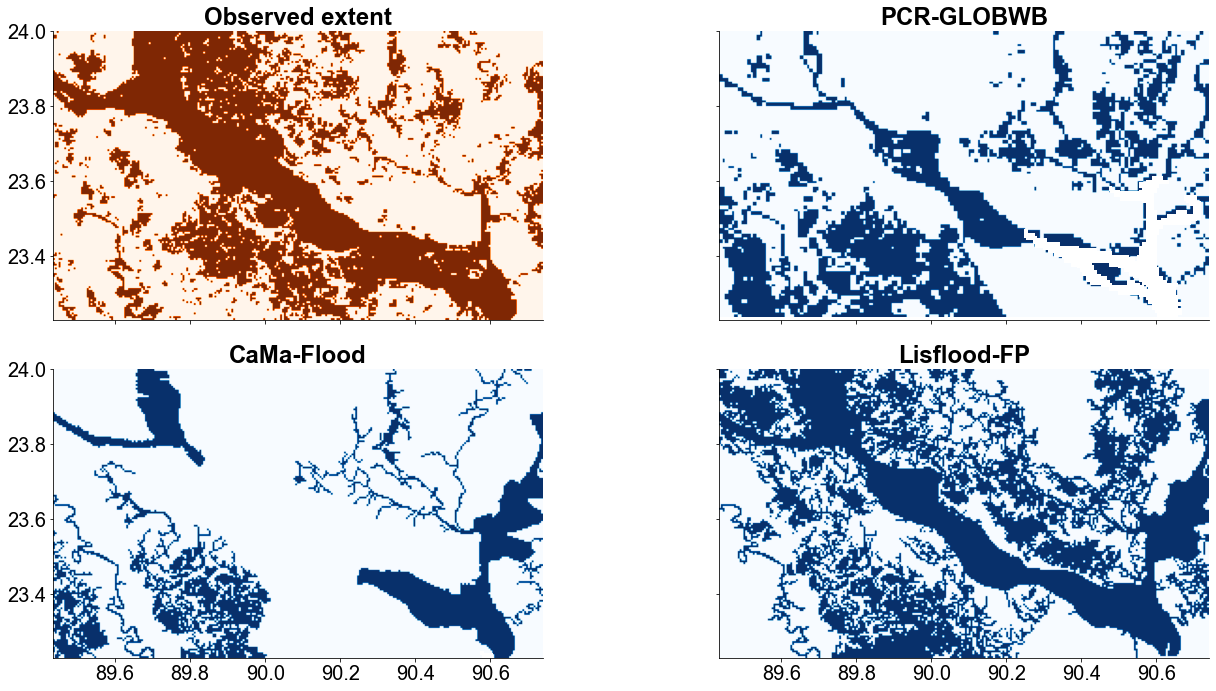

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), sharey=True, sharex=True)

show(OBS_d, ax=axes[0,0], cmap='Oranges', title='Observed extent')

show(PCR_d, ax=axes[0,1], cmap='Blues', title='PCR-GLOBWB')

show(CMF_d, ax=axes[1,0], cmap='Blues', title='CaMa-Flood')

show(LFP_d, ax=axes[1,1], cmap='Blues', title='Lisflood-FP')

plt.tight_layout()

sns.despine()

plt.savefig('out/flood_extents.png', dpi=300, bbox_inches='tight')

What we see here is that the simulated flood extents differ greatly. 

While PCR-GLOBWB has a somewhat intermediate extent, Lisflood-FP shows the biggest extent. This is most likely due to the fact that the model can simulated 2D floodplain flow and more complex channel-floodplain interactions, also via smaller channels. As outlined above, the flood extent from CaMa-Flood is obtained by static post-processing. What can be seen is that this can lead to problems when for some parts of a river reach the simulated water volume just remains within the river bed while for others not - a very sudden transition between flooded and not-flooded areas.

## Contingency analysis

But how well do the simulated extents match the observations? To understand this, we plot the Contingency maps and determine the values for the hit rate (HR), false alarm ratio (FAR), and critical success index (CSI). We refer to the NHESS publication for an explanation of those concepts.

In these plots, the color-coding is as follows:

* blue: simulated extent only
* red: observed extent only
* green: both

Model: PCR-GLOBWB
Hit rate: 0.384820
False Alarm rate: 0.440021
Critical success index: 0.295474

Model: CaMa-Flood
Hit rate: 0.301174
False Alarm rate: 0.402354
Critical success index: 0.250403

Model: Lisflood-FP
Hit rate: 0.701489
False Alarm rate: 0.421108
Critical success index: 0.464473



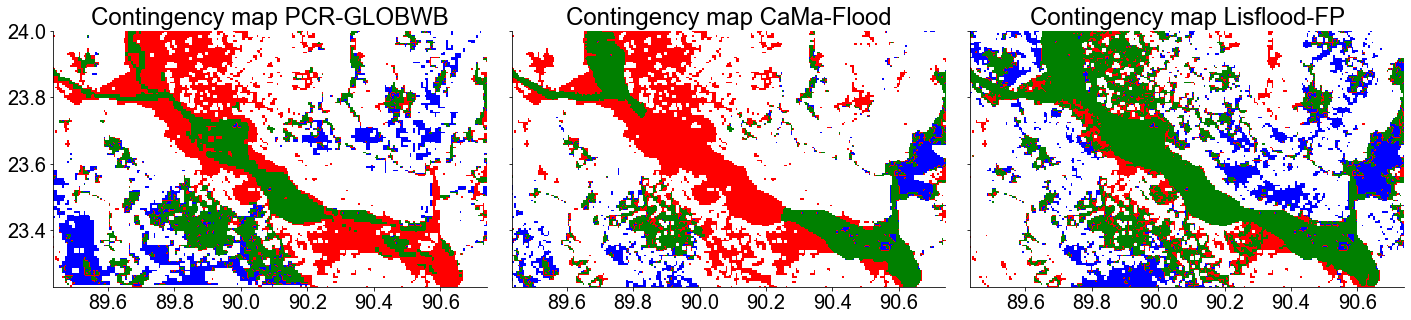

In [126]:
cmap = colors.ListedColormap(['blue', 'red', 'green'])
bounds=[0.5, 1.5, 2.5, 3.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(1, 3, figsize=(20,10), sharey=True)

for key, ax in zip(flood_maps.keys(), axes):

    hr, far, csi, cont_arr = contingency(OBS_d, flood_maps[key], 0.5, 0.)

    plot_image = np.ma.masked_where(cont_arr==0, cont_arr)

    img = ax.imshow(plot_image, cmap=cmap, vmin=1., vmax=3., extent=(OBS_d.bounds[0], OBS_d.bounds[2], OBS_d.bounds[1], OBS_d.bounds[3]))

    ax.set_title('Contingency map {:s}'.format(key))

#     cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[1, 2, 3], orientation='vertical')
    
    print('Model: {:s}'.format(key))
    print('Hit rate: {:f}'.format(hr))
    print('False Alarm rate: {:f}'.format(far))
    print('Critical success index: {:f}'.format(csi))
    print('')

plt.tight_layout()

sns.despine()
    
plt.savefig('out/contingency_maps.png', dpi=300, bbox_inches='tight')

It shows that simulating inundation maps can benefit greatly from adding 2D hydrodynamic floodplain flow computations. Validating the downscaled inundation maps from PCR-GLOBWB and CaMa-Flood with the modelled results of Lisflood-FP shows significant deviations. In fact, results insinuate that acceptable representation of inundation patterns as expressed by the CSI can only be achieved by also accounting for floodplain flow and discharge through side channels.

The differences in HR largely result from simulated inundations along smaller water bodies, especially compared to CaMa-Flood, and from simulating the extent across the entire river floodplain, which is particularly not the case for PCR-GLOBWB. It is for those areas, which may not necessarily be directly adjacent to the main river stem, that downscaling procedures based on volume or water depth distribution curves may not suffice to represent the actual locally relevant flood-triggering processes, leading to a low HR.

<a id="population"></a>
# Population

Let's check out the WorldPOP data in our study area. Seems there is only little population for the biggest part of the area and one bigger settlement in the N-E (guess this bigger settlment is Dhaka).

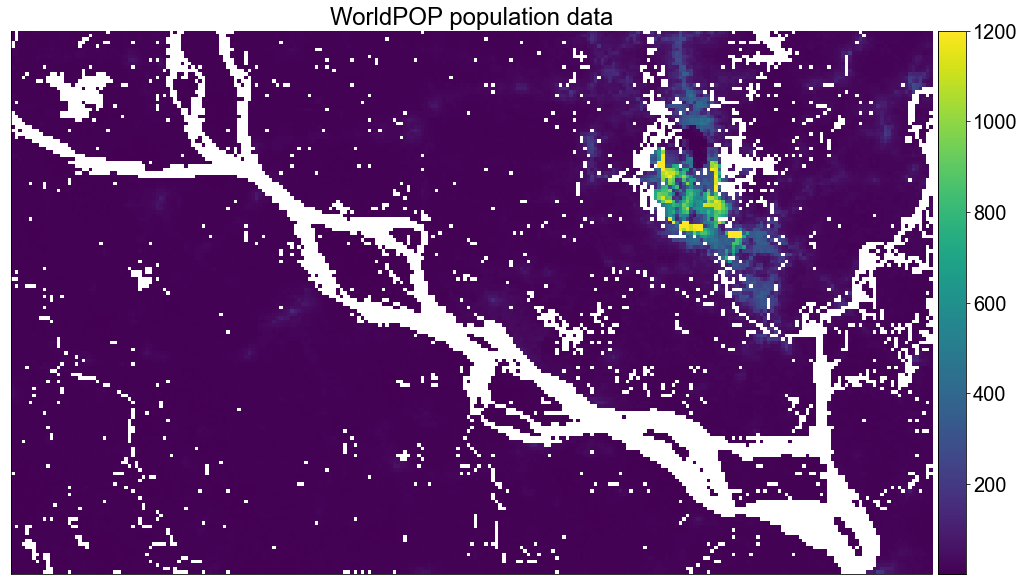

In [127]:
plot_image = np.ma.masked_where(POP_d.read(1)<=0, POP_d.read(1))

fig, ax = plt.subplots(1, 1, figsize=(20,10))
ep.plot_bands(plot_image, ax=ax, cmap='viridis', vmin=1., vmax=1200, title='WorldPOP population data')

sns.despine()

plt.savefig('out/population_data.png', dpi=300, bbox_inches='tight')

## Exposure

To assess the impact how the differences in simulated flood extent impact the number of casulaties in this flood event. This is done in a very simple first-order approach, where we overlay inundation maps with population data.

Note here that this of couse not a realistic value and does not say anyting about actual flood risk in the region!!!

First, we mask all cells with negative values (often the nodata values) with zeros to obtain sensible results from the multiplications.

In [128]:
POP_mask = POP_d.read(1) * np.greater(POP_d.read(1), 0.0)

We can now compute the number of people affected by the inundation event by multiplying the boolean map of the observations with the number of people per cell. This would give us a benchmark value to compare the other values with.

In [129]:
exposure_arr = OBS_d.read(1) * np.greater(OBS_d.read(1), 0.0) * POP_mask
exposure_sum = np.sum(exposure_arr)

print('People exposed with observed extent: {:f}'.format(exposure_sum))
print('')

People exposed with observed extent: 173291.875000



Let's now do the same with the simulated extents and see how many people would be affected with which model

People exposed with extent per model

Model: PCR-GLOBWB
People affected: 165277.687500

Model: CaMa-Flood
People affected: 75136.250000

Model: Lisflood-FP
People affected: 233572.375000



<ipython-input-130-e063393747fa>:11: RuntimeWarning: divide by zero encountered in log
  plot_image = np.log(np.ma.masked_where(exposure_arr<=0, exposure_arr))


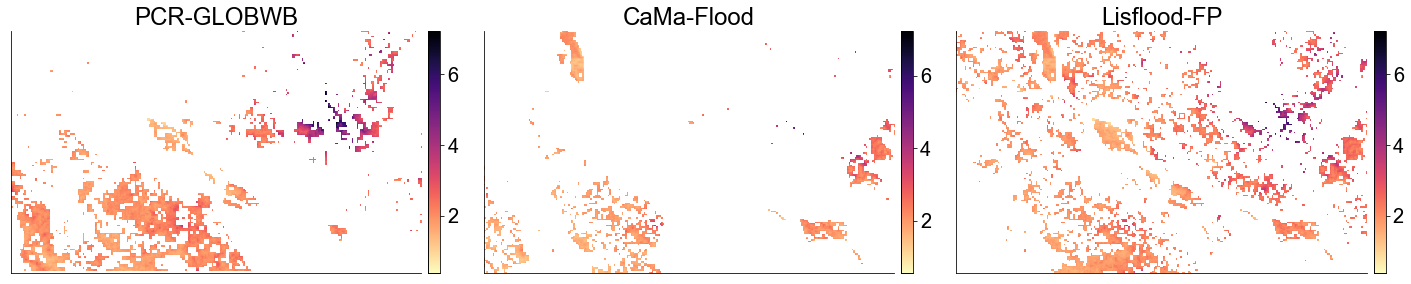

In [130]:
print('People exposed with extent per model')
print('')

fig, axes = plt.subplots(1, 3, figsize=(20,10), sharey=True)

for key, ax in zip(flood_maps.keys(), axes):

    exposure_arr = flood_maps[key].read(1) * np.greater(flood_maps[key].read(1), 0.0) * POP_mask
    exposure_sum = np.sum(exposure_arr)
    
    plot_image = np.log(np.ma.masked_where(exposure_arr<=0, exposure_arr))
    
    ep.plot_bands(plot_image, ax=ax, cmap='magma_r', title=key)
    
    print('Model: {:s}'.format(key))
    print('People affected: {:f}'.format(exposure_sum))
    print('')
    
sns.despine()

plt.tight_layout()
    
plt.savefig('out/people_affected.png', dpi=300, bbox_inches='tight')

We see that the results obtained with the downscaled PCR-GLOBWB model come closest to our benchmark value. This is interesting, because it is not the model performing best in the contingency analysis in terms of CSI!

Also if the FAR and HR of PCR-GLOBWB is compared with those of the other models, we cannot find a clear connection between the contingency analysis and the number of people affected. This may be because those funtions are determined for the entire study area, whereas the number of people affected is very much defined by model accuracy for a limited region.

## Future develoment (SSP2)

In [131]:
years = {2030:'./data/population_SSP2_5min_bc_2030_resampled.tiff',
         2040:'./data/population_SSP2_5min_bc_2040_resampled.tiff',
         2050:'./data/population_SSP2_5min_bc_2050_resampled.tiff'}

People exposed with extent per model in year 2030
POP data from file ./data/population_SSP2_5min_bc_2030_resampled.tiff



<ipython-input-132-9d9ce7115dfb>:16: RuntimeWarning: divide by zero encountered in log
  plot_image = np.log(np.ma.masked_where(exposure_arr<=0, exposure_arr))


Model: PCR-GLOBWB
People affected: 2580035072

Model: CaMa-Flood
People affected: 1294925568

Model: Lisflood-FP
People affected: 3441376768

People exposed with extent per model in year 2040
POP data from file ./data/population_SSP2_5min_bc_2040_resampled.tiff

Model: PCR-GLOBWB
People affected: 2680785920

Model: CaMa-Flood
People affected: 1372892416

Model: Lisflood-FP
People affected: 3595657728

People exposed with extent per model in year 2050
POP data from file ./data/population_SSP2_5min_bc_2050_resampled.tiff

Model: PCR-GLOBWB
People affected: 2781536512

Model: CaMa-Flood
People affected: 1450859136

Model: Lisflood-FP
People affected: 3749939200



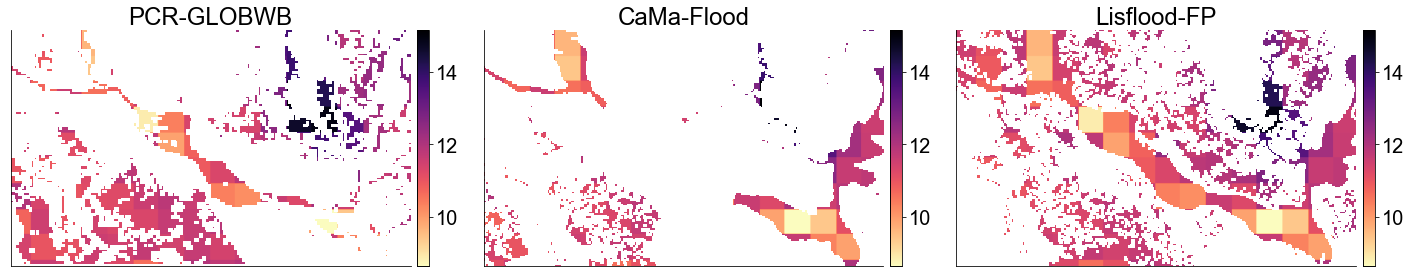

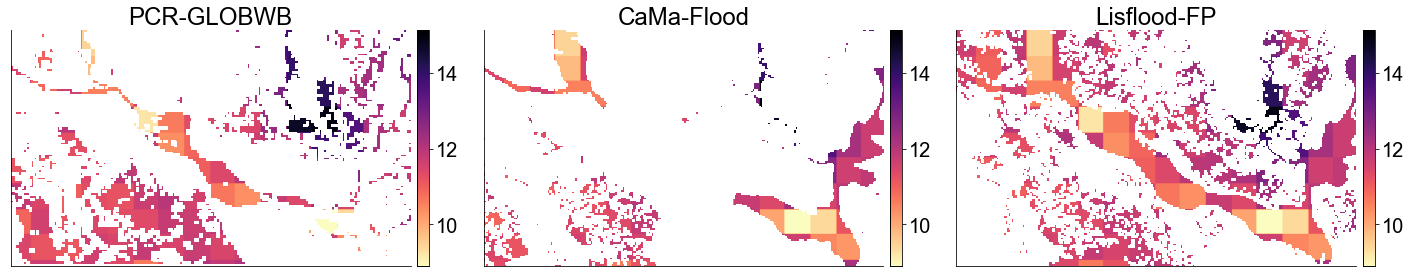

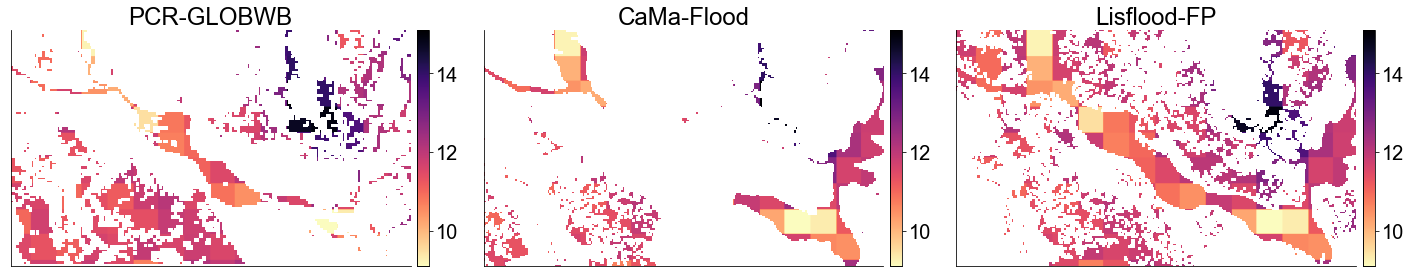

In [132]:
for year in years.keys():
    
    print('People exposed with extent per model in year {}'.format(year))
    print('POP data from file {}'.format(years[year]))
    print('')
    POP_d = rio.open(years[year])
    POP_mask = POP_d.read(1) * np.greater(POP_d.read(1), 0.0)

    fig, axes = plt.subplots(1, 3, figsize=(20,10), sharey=True)

    for key, ax in zip(flood_maps.keys(), axes):

        exposure_arr = flood_maps[key].read(1) * np.greater(flood_maps[key].read(1), 0.0) * POP_mask
        exposure_sum = np.sum(exposure_arr)

        plot_image = np.log(np.ma.masked_where(exposure_arr<=0, exposure_arr))

        ep.plot_bands(plot_image, ax=ax, cmap='magma_r', title=key)

        print('Model: {:s}'.format(key))
        print('People affected: {:0.0f}'.format(exposure_sum))
        print('')
        
        exposure[key].append(exposure_sum)

    sns.despine()
    
    plt.tight_layout()
    
    plt.savefig('out/people_affected_SSP2.png', dpi=300, bbox_inches='tight')

In [133]:
test = pd.DataFrame.from_dict(exposure)
test.index = [2030,2040,2050]

In [134]:
test

,PCR-GLOBWB,CaMa-Flood,Lisflood-FP
2030,2.580035e+09,1.294926e+09,3.441377e+09
2040,2.680786e+09,1.372892e+09,3.595658e+09
2050,2.781537e+09,1.450859e+09,3.749939e+09


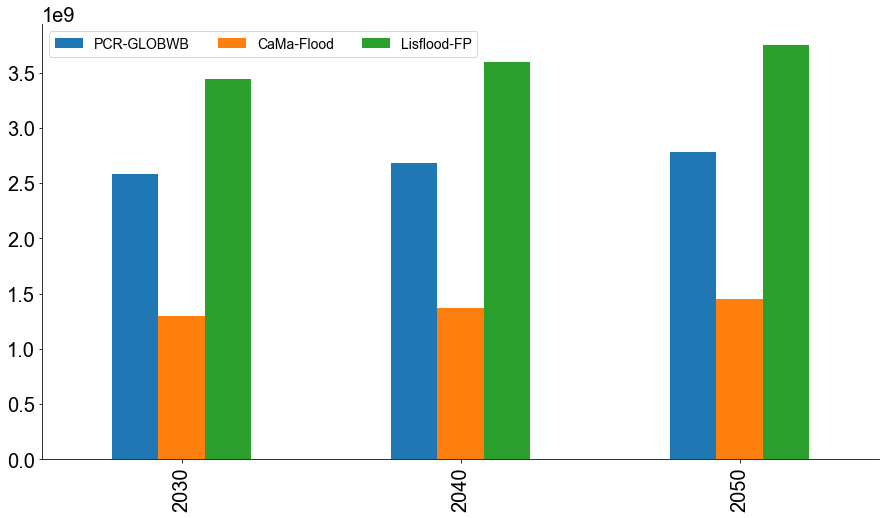

In [135]:
sns.color_palette("colorblind")

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
test.plot.bar(ax=ax)
sns.despine()
plt.legend(ncol=3, loc=2, fontsize=14)

plt.savefig('out/people_affected_barplot_SSP2.png', dpi=300, bbox_inches='tight');

In [136]:
print('increase PCR-GLOBWB 2030-2050 {:0.2f}'.format(test['PCR-GLOBWB'].values[-1] / test['PCR-GLOBWB'].values[0]))
print('increase CaMa-Flood 2030-2050 {:0.2f}'.format(test['CaMa-Flood'].values[-1] / test['CaMa-Flood'].values[0]))
print('increase Lisfood-FP 2030-2050 {:0.2f}'.format(test['Lisflood-FP'].values[-1] / test['Lisflood-FP'].values[0]))

increase PCR-GLOBWB 2030-2050 1.08
increase CaMa-Flood 2030-2050 1.12
increase Lisfood-FP 2030-2050 1.09


<a id="conclusion"></a>
# Conclusion

This small analysis shows us that the model choice has a great influence on not only flood extent accuracy, but also on the number of people affected.

Such a finding is particularly relevant for flood management plans and flood risk assessments, which often rely heavily on model output. It is clear that there is not this one model outperforming all others, but that some model properties may be more relevant is certain regions than in others. 

With a large ensemble of flood models available, this work highlights the need for more structured flood model inter-comparison frameworks <cite data-cite="6222060/WE46DM4F"></cite>.

The results obtaind may lead to questions on how to actually validate flood models. Modelled flood extent is commonly used for validating and calibrating models. But in this case, if we had chosen the model with the most accurate output (expressed as highest CSI), we would have stongly overpredicted the number of people affected compared to the benchmark value.

And while it remains very important to validate and calibrate flood models over large areas and entire flood events, there may also be the case for additional procedures focussing more on correctly representing flood losses - even if the overall accuracy may be reduced.

What do you think?

## Code

The GLOFRIM code used for producing the inundation maps can be found [here](https://doi.org/10.5281/zenodo.3364388).

This notebook and all underlying data is hosted on [GitHub](https://github.com/JannisHoch/shareEGU20) and ready to be forked!

## Acknowledgments

Part of the code for calculating the contingency maps is borrowed from Hessel Winsemius. Many thanks!

# References

<div class="cite2c-biblio"></div>